In [2]:
# package libraries
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Activation,Conv2D
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler,TensorBoard,ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image

import os
from os import listdir
from os.path import isfile, join 
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import random
from collections import Counter
from glob import iglob
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import os, random
import matplotlib.pyplot as plt
import numpy as np
import pickle

import itertools
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [3]:
# https://github.com/pmarcelino/blog/blob/master/dogs_cats/dogs_cats.ipynb
# https://cv-tricks.com/keras/understand-implement-resnets/
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

# Data Augmentation
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

# https://yashuseth.blog/2018/11/26/hyper-parameter-tuning-best-practices-learning-rate-batch-size-momentum-weight-decay/
# https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

# https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

### Model setting

In [4]:
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

BATCH_SIZE = 12
EPOCHS = 20
STEP_PER_EPOCHS = 50

### Read image dataset

In [5]:
base_dir = 'dataset_v1'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
predict_dir = os.path.join(base_dir, 'predict')

### Creating objects for image augmentations

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=90,
                                   vertical_flip=True,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale = 1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1588 images belonging to 4 classes.
Found 317 images belonging to 4 classes.


### Object image

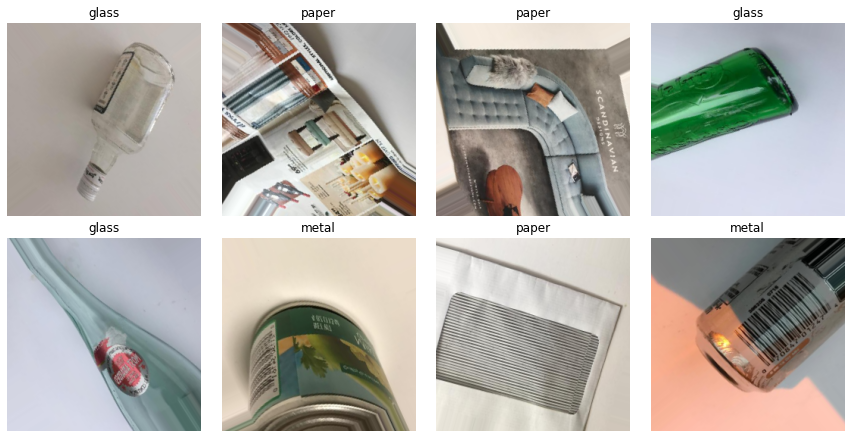

In [7]:
def plot(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')
        

def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())
     
    plt.figure(figsize=(10,10))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()
    

x,y = next(train_generator) 
y_int = np.argmax(y,axis=-1)

class_mapping = {v:k for k,v in train_generator.class_indices.items()}

plot(x,2,4,label_list=y_int,show_labels=True,figsize=(15,10))

### Download the architecture of ResNet50 with ImageNet weights

In [8]:
base_model = ResNet50(include_top=False, 
                      weights='imagenet',
                      input_shape=INPUT_SHAPE)

C:\Users\kaush\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
x = base_model.output

In [10]:
# Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x) 

x = Dense(1024, activation='relu')(x)

In [11]:
# give the probability
predictions = Dense(4, activation='softmax')(x)
 
# Model to be trained
model = Model(inputs=base_model.input, outputs=predictions) 

In [12]:
# Compiling the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.0001), 
              loss='categorical_crossentropy', 
              metrics = ['accuracy'])

earlystopping = EarlyStopping(monitor='loss',patience=3,verbose=1)

### Fit model

In [13]:
model_history = model.fit_generator(train_generator,
                    steps_per_epoch = STEP_PER_EPOCHS, epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps=STEP_PER_EPOCHS,
                    callbacks=[EarlyStopping(monitor='loss',patience=3,verbose=1)])

Epoch 1/20
50/50 [==============================] - 504s 10s/step - loss: 1.2428 - accuracy: 0.4341 - val_loss: 1.6611 - val_accuracy: 0.2530
Epoch 2/20
50/50 [==============================] - 463s 9s/step - loss: 0.9297 - accuracy: 0.6283 - val_loss: 2.4059 - val_accuracy: 0.2628
Epoch 3/20
50/50 [==============================] - 546s 11s/step - loss: 0.7325 - accuracy: 0.7467 - val_loss: 2.8781 - val_accuracy: 0.2816
Epoch 4/20
50/50 [==============================] - 464s 9s/step - loss: 0.6316 - accuracy: 0.7551 - val_loss: 2.5919 - val_accuracy: 0.2628
Epoch 5/20
50/50 [==============================] - 511s 10s/step - loss: 0.5685 - accuracy: 0.7833 - val_loss: 2.2954 - val_accuracy: 0.2662
Epoch 6/20
50/50 [==============================] - 537s 11s/step - loss: 0.5212 - accuracy: 0.8083 - val_loss: 3.8998 - val_accuracy: 0.2799
Epoch 7/20
50/50 [==============================] - 536s 11s/step - loss: 0.4835 - accuracy: 0.8361 - val_loss: 4.1281 - val_accuracy: 0.2159
Epoch 8/

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

bn3a_branch2c (BatchNormalizati (None, 32, 32, 512)  2048        res3a_branch2c[0][0]             
__________________________________________________________________________________________________
bn3a_branch1 (BatchNormalizatio (None, 32, 32, 512)  2048        res3a_branch1[0][0]              
__________________________________________________________________________________________________
add_4 (Add)                     (None, 32, 32, 512)  0           bn3a_branch2c[0][0]              
                                                                 bn3a_branch1[0][0]               
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 32, 32, 512)  0           add_4[0][0]                      
__________________________________________________________________________________________________
res3b_branch2a (Conv2D)         (None, 32, 32, 128)  65664       activation_13[0][0]              
__________

In [15]:
train_generator.class_indices

{'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3}

### Evaluate test dataset

In [16]:
train_result = model.evaluate(train_generator) 
test_result = model.evaluate(test_generator) 

print('Model loss %.2f and,'
      'accuracy of %.2f%% training dataset.' % (train_result[0], train_result[1]*100)) 

print('Model loss %.2f and,'
      'accuracy of %.2f%% test dataset.' % (test_result[0], test_result[1]*100)) 

27/27 [==============================] - 77s 3s/step
Model loss 3.01 and,accuracy of 27.83% training dataset.
Model loss 2.19 and,accuracy of 30.28% test dataset.


### Extract features and label trained CNN model 

In [17]:
data_gen = ImageDataGenerator(rescale=1./255)
sample_count = 1588

def extract_features():
    features = np.zeros(shape=(sample_count,4))
    labels = np.zeros(shape=(sample_count,4))
    # Preprocess data
    generator = data_gen.flow_from_directory(train_dir,
                                            target_size=IMAGE_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features()

Found 1588 images belonging to 4 classes.


### Train and fit SVC classifier

In [18]:
svm = SVC(kernel='rbf', C=1000, gamma=0.5)
 
svm.fit(train_features,np.argmax(train_labels,axis=1))

print('SVM classifier training done.')

SVM classifier training done.


### SVC classifier score

In [19]:
svm.score(train_features,np.argmax(train_labels,axis=1))

0.5295969773299748

### Model accuracy and loss plots

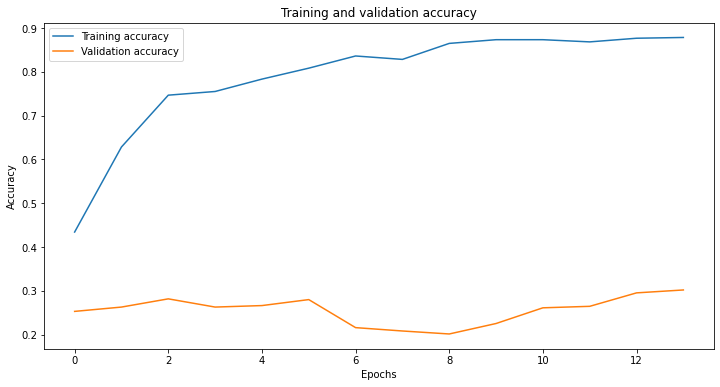

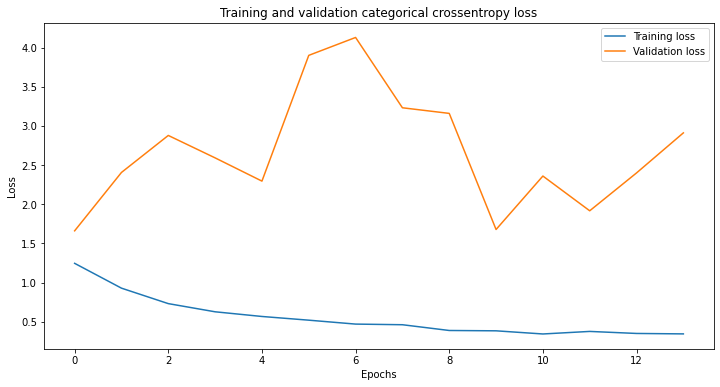

In [20]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and validation categorical crossentropy loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


model_performance_plot(model_history)

### Predict new images

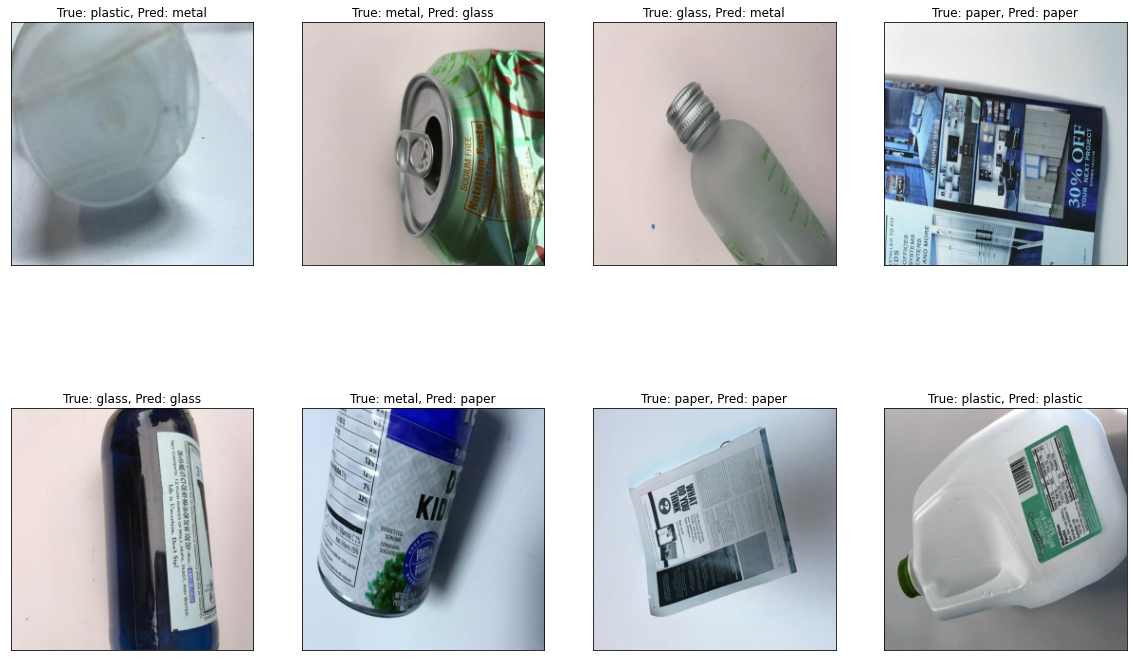

In [44]:
# Plot function 

def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles),nrows*ncols,replace=False)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img_tensor = image.img_to_array(img)
        img_tensor /= 255.
        
        # Extract features
        features = model.predict(img_tensor.reshape(1,IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        
        prediction = svm.predict(features)
        index = int(prediction[0])
            
        title = 'True: %s, Pred: %s' % (true_type,class_mapping[index])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
# ploat image with predicted and actual value
num_rows = 2
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]
plot_predicted_label(num_rows, num_cols,onlyfiles);

### Save model

In [23]:
model_filename = "model_resnet50.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)    

model.save('model_resnet50.h5')

model_filename = "svm_resnet50.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(svm, file)